**Labb 3**



Johannes Hedström



In [ ]:
# Import needed libraries
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

# from tensorflow import keras
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.utils  import to_categorical

# print('Keras version:',tf.keras.__version__)

# Matlab plotting
import matplotlib
import matplotlib.pyplot as plt
#mpl.rcParams['figure.figsize'] = (8, 6)
#mpl.rcParams['axes.grid'] = False

# Helper libraries
import os
import datetime

import numpy as np
import pandas as pd
import sklearn
from   sklearn.model_selection import train_test_split

import IPython
import IPython.display
import seaborn as sns

TensorFlow version: 2.12.0


In [ ]:
# L'ser in datamaterialet
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)
df = pd.read_csv(csv_path)

13568290/13568290 [==============================] - 2s 0us/step


In [ ]:
print(df.head(10))

             Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0  01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
1  01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2  01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
3  01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
4  01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04    94.1   
5  01.01.2009 01:00:00    996.50     -8.05    265.38        -8.78    94.4   
6  01.01.2009 01:10:00    996.50     -7.62    265.81        -8.30    94.8   
7  01.01.2009 01:20:00    996.50     -7.62    265.81        -8.36    94.4   
8  01.01.2009 01:30:00    996.50     -7.91    265.52        -8.73    93.8   
9  01.01.2009 01:40:00    996.53     -8.43    264.99        -9.34    93.1   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
0          3.33          3.11          0.22       1.94             3.12   
1 

# Del 1

Kommentarer på frågorna kommer rullande och inte som en summering på slutet.

Tittar på hur datamaterialet ser ut innan manipulering, tidsnivån i datamaterialt från början är 10 min

In [ ]:
# This lab will just deal with hourly predictions, so start by sub-sampling the data from 10 minute intervals to 1h:
df = df[5::6] # starting from index 5 take every 6th record.

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
print(df.shape)
# Let's take a glance at the data. Here are the first few rows:
df.head()

(70091, 14)


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Valt ut var sjätte observation för att få timmdata istället, börjar från observation 5 vilket var den första timmen i datamaterialet.

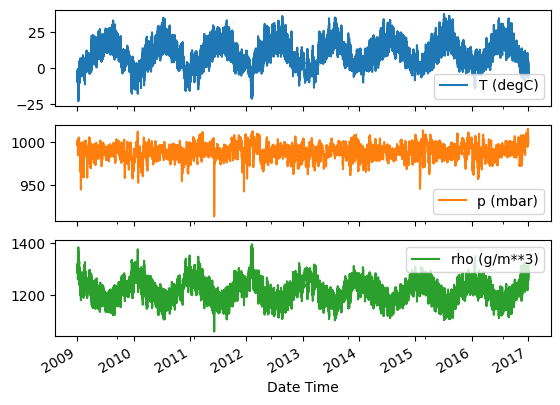

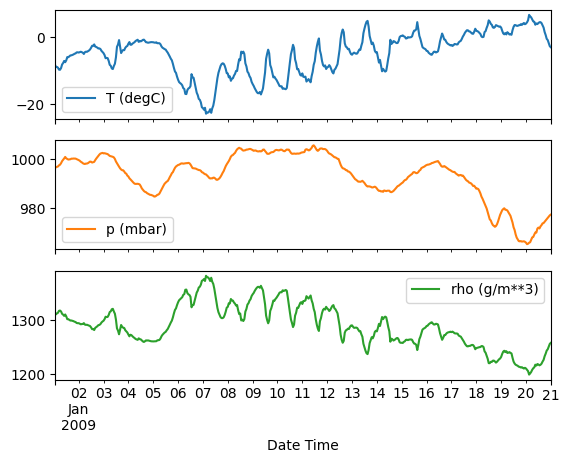

In [ ]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

Plottar några variabler för att se hur tidersierna beter sig, både en lägre och en kortare tisserie för att se säsonger över längre tid och mer detaljer på kortare. Det är väldigt stor skillnad mellan variablerna, tex är lufttrycket mer stationär än temperatur och lufttätheten. En annan tydlig skillnad är att Säsongerna inom temperatur och lufttätheten går emot varandra vilket syns på trenderna på den "inzoomade" tidsserien för år januari 2009 men att säsongerna är mycket längre än en månad.  

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


Magnituden och variansen på variablerna skiljer sig väldigt mycket, till exempel har lufttrycket ett medelvärde på 989 medan temperaturen har medel på runt 9, intressant nog har dem relativt lika standardavvikelse. En variabel som verkligen sticker ut är vindhastigheten då standardavvikelsen är otroligt mycket större än medelvärdet, vi ser tex att minsta värdet är -9999(kodar om till 0). En annan variabel som måste hanteras är vindens riktning som rör sig mellan 0 och 360 den här skalan måste hanteras då vinklar nära 360 även är nära 0, detta kommer hanteras genom att konvertera graderna till radianer och den cirkulera egenskapen gör att dem nu hamnar nära varandra.

Text(0, 0.5, 'Wind Velocity [m/s]')

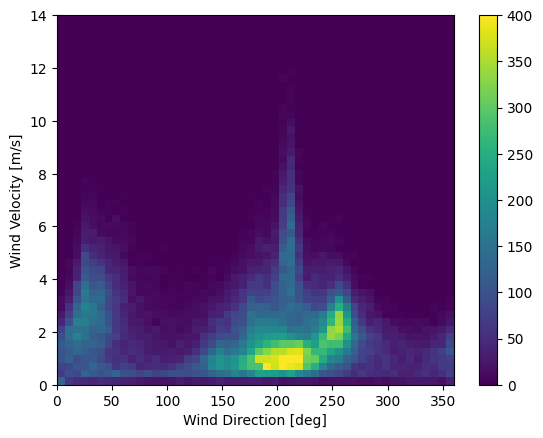

In [ ]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0 ## Alla värde som är -9999 räknas som 0 istället

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame
df['wv (m/s)'].min()


plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

(-11.30551397313467, 8.244699285490789, -8.274385403355149, 7.733831295546778)

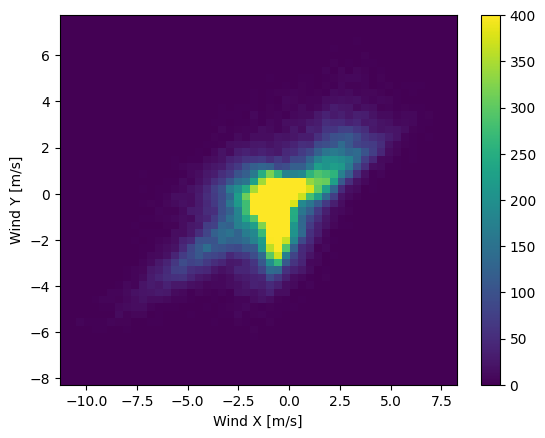

In [ ]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

Text(0.5, 1.0, 'Time of day signal')

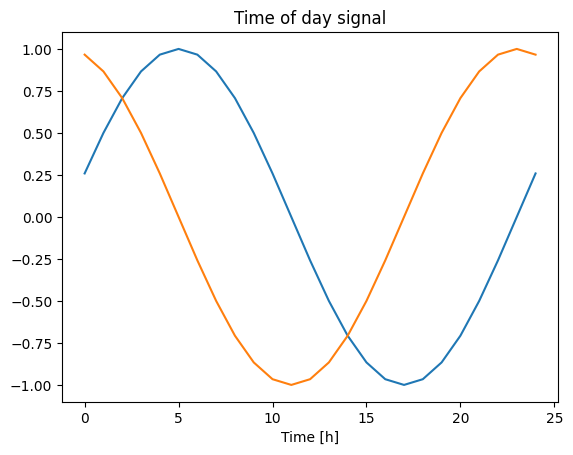

In [ ]:
timestamp_s = date_time.map(datetime.datetime.timestamp) # Gör om til sekunder
day = 24*60*60 # Antal sekunder per dag
year = (365.2425)*day # Antal dagar per år plus skottår/4 gånger antalet sekunder per dag

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day)) # Dagskurva
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day)) # Dagskurva
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year)) # årlig kurva
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year)) # årlig kurva
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

Eftersom tidsseriens trender, mönster eller säsonger rör sig över långa tidsspann som kan vara dagar, veckor, månader eller år så är det inte relevant att ha data på sekundnivå. Kurvor läggs in på dags- och års-nivå för att plocka upp dessa mönster. För att se att just en dag och ett år är rimligt så kan man kolla på Fast Fourier Transform vilket innebär att man transformerar en tidsserie-signal till dess frekvensrepresentation, vilket ger infromation om vilka frekvenser som finns i signalen och deras nivå. Nedan visas kod när detta testas på variabeln temperatur.

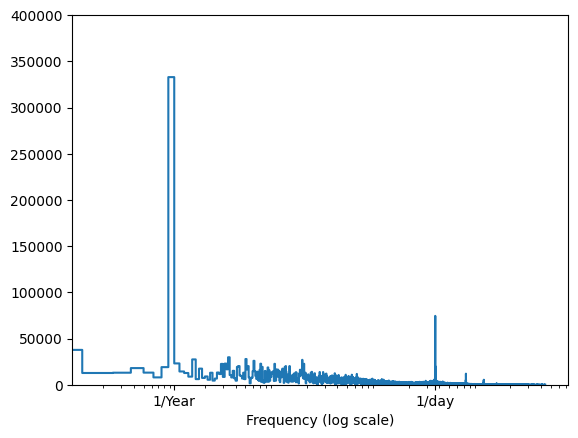

In [ ]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

Grafen visar tydliga spikar på 1/år och ett/dag vilket tyder på att våra kurvor är på rätt tidsintervall.

Energiförbrukningsdata har troligtvis en periodisitet på vinter/sommar eller alla 4 årstider då mer energi används för att värma upp hus och fastigheter under de kallare årstiderna.

In [ ]:
# Find index to where we want to split our data into our datasets
DataSplitRatios=(0.7,0.2,0.1) # Maybe one should check this sums up to 1?
n = len(df)
split1ix = int(n*DataSplitRatios[0]+1)
split2ix = int(n*(DataSplitRatios[0]+DataSplitRatios[1])+1) # la till +1 på träningsmängden för att inte tappa en observation

print(split1ix,split2ix,n)
print(split2ix + int(n*DataSplitRatios[2]))


49064 63082 70091
70091


Uppdelningen av datat summerar ihop till samma

In [ ]:
train_mean = df[0:split1ix].mean()
train_std = df[0:split1ix].std()
dfnorm = (df - train_mean) / train_std # normaliserar data

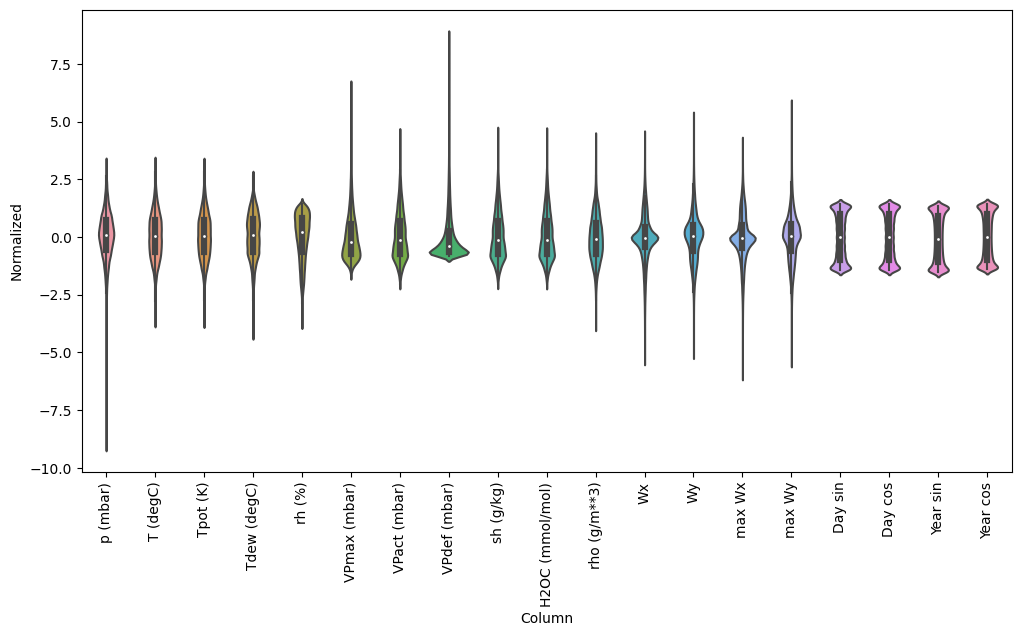

In [ ]:
df_std = dfnorm.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

Val av förlustfunktion beror lite på hur fördelningen ser ut för targetvariabeln, MSE är ofta mer pricksäker än MAE men kräver för det att targetvariabeln ska vara normalfördelad. MAE är mer robust om det finns outliers i datat för targetvariabeln och kommer då ge troligtvis ge ett bättre resultat mot MSE och kräver bara att fördelningen ska vara symmetriska och tillåter då mer extrema värden åt båda hållen runt medelvärdet. Den variabeln som ser normalfördelad i datamaterialet ut är temperatur så om det är variabeln som ska predikteras så kommer MSE troligtvis fungera bättre än MAE, men det är möjligt att svansarna är något långa och då hade MAE varit det bättre valet. Att välja MAE som utvärderingsmått kan däremot vara rimligt då den är mer lättolkad då det är medelvärdet på absolutbeloppet av felen och inte kvadrerat.

Så jag kommer välja att köra likadant som tutorialen med MSE som förlustfunktion då jag tycker temperatur ser normalfördelat ut, men kommer också att använda MSE som utvärderingsmått då modellen tränas för att förbättra det måttet.


Följande kod konverterar tidsserien till kortare sekvenser med lämpliga utvärden:

In [ ]:
# Help function to get indices for columns based on column names
def get_label_columns_indices(dataframe,label_columns=None):
  if label_columns is not None:
    label_columns_indices = {name: i for i, name in enumerate(label_columns)}
  else:
    label_columns_indices = {name: i for i, name in enumerate(dataframe.columns)}
  return label_columns_indices

In [ ]:
# Test get_label_columns_indices
#lcol= ['T (degC)']
lcol= None
lci = get_label_columns_indices(dfnorm,lcol)
print(lci)

{'p (mbar)': 0, 'T (degC)': 1, 'Tpot (K)': 2, 'Tdew (degC)': 3, 'rh (%)': 4, 'VPmax (mbar)': 5, 'VPact (mbar)': 6, 'VPdef (mbar)': 7, 'sh (g/kg)': 8, 'H2OC (mmol/mol)': 9, 'rho (g/m**3)': 10, 'Wx': 11, 'Wy': 12, 'max Wx': 13, 'max Wy': 14, 'Day sin': 15, 'Day cos': 16, 'Year sin': 17, 'Year cos': 18}


In [ ]:
# Here is our function that take our time sequence data and convert it to a dataset
# that then can be us as a dataset for training or evaluation
def datasetgen(dataframe, input_width=24, label_width=1, shift=1, batch_size=128,
               label_columns=None, start_index=None, end_index=None, shuffle=False):
  offset = input_width+shift         # offset to where targets start (and input ends)
  input_data = dataframe[:-offset]   # Input up until where the target starts
  label_columns_indices = get_label_columns_indices(dataframe,label_columns) # get the selected columns
  targets = dataframe[list(label_columns_indices)]
  targets = targets[offset:]         # Output from end of input and for the selected columns
  # Here we create the windows and store them as a dataset using 'timeseries_dataset_from_array'
  train_ds = tf.keras.utils.timeseries_dataset_from_array(
    input_data, targets, sequence_length=input_width,
    sequence_stride=1, sampling_rate=1, batch_size=batch_size, shuffle=shuffle,
    start_index=start_index, end_index=end_index)
  return train_ds

In [ ]:
# Now create the used datasets for part 1
lcol=['T (degC)'] # väljer temperatur som target
train_ds = datasetgen(dfnorm, input_width=24, label_width=1, shift=1,
              label_columns=lcol, start_index=0, end_index=split1ix)
val_ds = datasetgen(dfnorm, input_width=24, label_width=1, shift=1,
              label_columns=lcol, start_index=split1ix, end_index=split2ix)
test_ds = datasetgen(dfnorm, input_width=24, label_width=1, shift=1,
              label_columns=lcol, start_index=split2ix, end_index=None)

In [ ]:
# Establish test targets (unroll dataset)
test_targets = None
for batch in test_ds:
  inputs, targets = batch
  if test_targets == None:
    test_targets = targets
  else:
   test_targets = tf.concat([test_targets,targets], axis=0)

# And number of features
num_target_features = targets.shape[1]

lci = get_label_columns_indices(dfnorm,lcol)

In [ ]:
# Get a batch and look at the shapes for one of the datasets
eval_ds = test_ds
for batch in eval_ds:
  inputs, targets = batch
  batchlen = len(inputs)
  # We here have a batch of seqlen sequences
  print("Input shape = {0}, Output shape = {1}".format(inputs.shape,targets.shape))
  break
# Print dataset size
nobatches = eval_ds.__len__()
print("No sequences =", nobatches.numpy() * batchlen)

Input shape = (128, 24, 19), Output shape = (128, 1)
No sequences = 7040


In [ ]:
MAX_EPOCHS = 45

# funktion för träningsproceduren
def compile_and_fit(model, patience=3):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', # Earlystopping
                                                    patience=patience,
                                                    mode='min',
                                                    restore_best_weights = True)

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanSquaredError()]) # bytt mått till MSE här

  history = model.fit(train_ds, epochs=MAX_EPOCHS,
                      validation_data=val_ds,
                      callbacks=[early_stopping])

  return history,model



In [ ]:
# Define a first simple LSTM model with 32 units
lstm_model_baseline = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_target_features)
])


# Compile and train this model
history_lstm_baseline,lstm_model_baseline1=compile_and_fit(lstm_model_baseline)

Epoch 1/30
384/384 [==============================] - 21s 27ms/step - loss: 0.0892 - mean_squared_error: 0.0892 - val_loss: 0.0354 - val_mean_squared_error: 0.0354
Epoch 2/30
384/384 [==============================] - 11s 28ms/step - loss: 0.0328 - mean_squared_error: 0.0328 - val_loss: 0.0445 - val_mean_squared_error: 0.0445
Epoch 3/30
384/384 [==============================] - 13s 33ms/step - loss: 0.0255 - mean_squared_error: 0.0255 - val_loss: 0.0351 - val_mean_squared_error: 0.0351
Epoch 4/30
384/384 [==============================] - 10s 27ms/step - loss: 0.0218 - mean_squared_error: 0.0218 - val_loss: 0.0321 - val_mean_squared_error: 0.0321
Epoch 5/30
384/384 [==============================] - 10s 26ms/step - loss: 0.0196 - mean_squared_error: 0.0196 - val_loss: 0.0275 - val_mean_squared_error: 0.0275
Epoch 6/30
384/384 [==============================] - 10s 27ms/step - loss: 0.0181 - mean_squared_error: 0.0181 - val_loss: 0.0253 - val_mean_squared_error: 0.0253
Epoch 7/30
384/3

Earlystopping stannar träningen efter 11 epoker för att stoppa ytterligare överanpassning

Test accuracy: 0.021


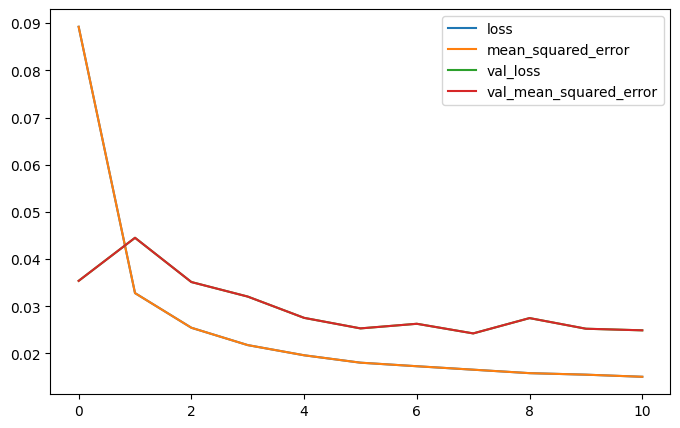

In [ ]:
# Evaluate the model.
test_loss, test_mse = lstm_model_baseline1.evaluate(test_ds, verbose=0)
print('Test MSE: %.3f' % test_mse)

# Plot the training curves
pd.DataFrame(history_lstm_baseline.history).plot(figsize=(8,5))
plt.show()

Modellens överanassning börjar runt epok 7 i träningen

In [ ]:
# define a plot function to show how well it is prediction
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return

4/4 [==============================] - 0s 5ms/step


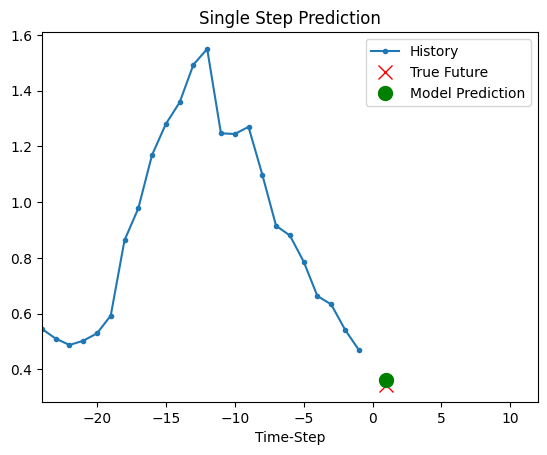

4/4 [==============================] - 0s 5ms/step


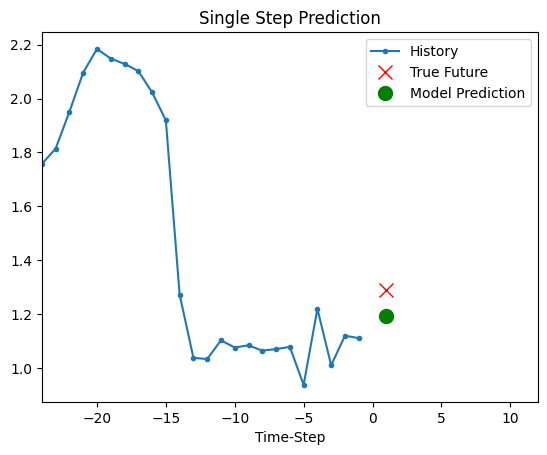

4/4 [==============================] - 0s 5ms/step


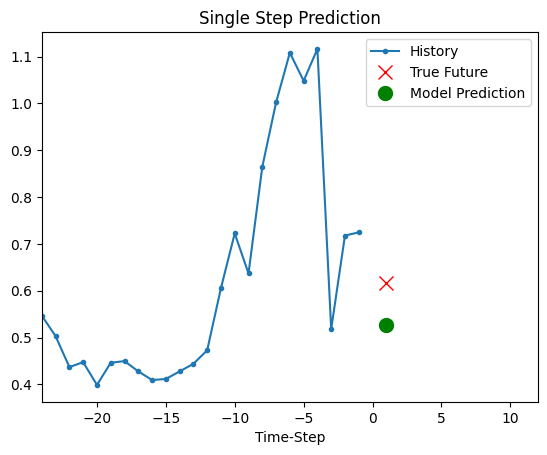

In [ ]:
for x, y in val_ds.take(3):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), lstm_model_baseline1.predict(x)[0]],
        1,
        "Single Step Prediction",
    )

När trenden är negativ och nästa värde följer samma trend har modellen lätt att prediktera värdet men har lite problem med andra mönster.

In [ ]:
# MSE för modellen
base_pred = lstm_model_baseline1.predict(test_ds)

MSE = np.mean((test_targets -np.array(base_pred))**2) # beräknar MSE

print(MSE) # Printar MSE


55/55 [==============================] - 1s 24ms/step
0.021147648686516994


MSE på testdata är för modellen är runt 0.21

# Baseline


In [ ]:
# Skapar en baseline funktion där nästa värde är samma som nuvarande värde (naive)

def baseline_pred(data):
    predictions = []
    for i in range(1, len(data)):
        y_pred = data[i-1]
        predictions.append(y_pred)
    return predictions

y_pred = baseline_pred(test_targets)


MSE = np.mean((test_targets[1:] -y_pred)**2) # beräknar MSE

print(MSE) # Printar MSE

0.014183013441978627


Baseline som bara tar nuvarande värde och ger nästa tidpunkt det värdet får ett MSE på 0.014 vilket är väldigt lågt, därav är en naive baseline en bra modell för att göra prediktioner en tidpunkt framåt. Men den kommer inte kunna fånga upp mönster för prediktioner längre fram i tiden. Den här modellen får lägre MSE än baseline_lstm.

*Skapar en förbättrad LSTM-modell*


In [ ]:
# Define a first simple LSTM model with 32 units
lstm_model_2 = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True,recurrent_regularizer=tf.keras.regularizers.l2(0.1)), # lägger in l2(ridge)-regularisering på recurrent-vikterna
    tf.keras.layers.LSTM(16, return_sequences=False, recurrent_regularizer=tf.keras.regularizers.l2(0.01)), # lagt in ett  till lager med fler noder
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_target_features)
])

# Compile and train this model
history_mod2,lstm_model_2=compile_and_fit(lstm_model_2)

# MSE för modellen
pred_m2 = lstm_model_2.predict(test_ds)

MSE = np.mean((test_targets -np.array(pred_m2))**2) # beräknar MSE

print(MSE) # Printar MSE



Epoch 1/45
384/384 [==============================] - 18s 37ms/step - loss: 0.8009 - mean_squared_error: 0.1750 - val_loss: 0.1089 - val_mean_squared_error: 0.0589
Epoch 2/45
384/384 [==============================] - 14s 37ms/step - loss: 0.0841 - mean_squared_error: 0.0581 - val_loss: 0.0928 - val_mean_squared_error: 0.0788
Epoch 3/45
384/384 [==============================] - 15s 39ms/step - loss: 0.0569 - mean_squared_error: 0.0473 - val_loss: 0.0631 - val_mean_squared_error: 0.0565
Epoch 4/45
384/384 [==============================] - 12s 31ms/step - loss: 0.0443 - mean_squared_error: 0.0392 - val_loss: 0.0578 - val_mean_squared_error: 0.0539
Epoch 5/45
384/384 [==============================] - 11s 29ms/step - loss: 0.0395 - mean_squared_error: 0.0362 - val_loss: 0.0529 - val_mean_squared_error: 0.0503
Epoch 6/45
384/384 [==============================] - 11s 29ms/step - loss: 0.0350 - mean_squared_error: 0.0326 - val_loss: 0.0511 - val_mean_squared_error: 0.0490
Epoch 7/45
384/3

Modellens träning tar mycket längre tid än tidigare och överanpassning verkar då inte vara samma problem när vikterna regulariseras då fler epoker körs, fick höja antalet epoker från 30 till 45 för att modellen regulariserade så bra och den lär sig sakta. Den predikterar bättre än den tidigare LSTM-modellen men klarar inte riktigt av att slå de naiva prediktionerna. Modellen tränas på alla 45 epoker och valideringsfelet fortsätter att sjunka rakt igenom hela träningen och modellen kan då egentligen fortsätta att tränas men jag väljer att stanna här då en GRU-modell också ska skapas med liknande regularisering som den här modellen.

Test-MSE är 0.018 vilket får ses som en bra förbättring

4/4 [==============================] - 0s 4ms/step


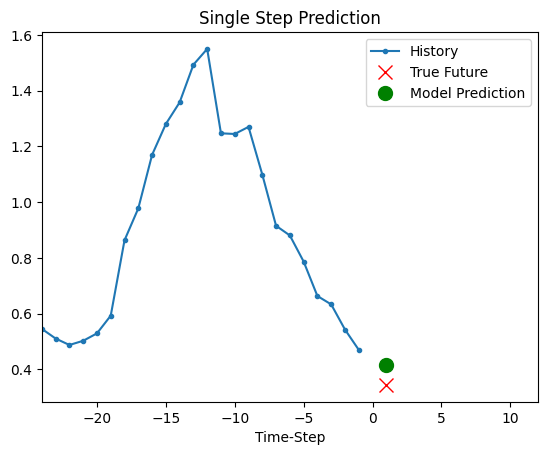

4/4 [==============================] - 0s 4ms/step


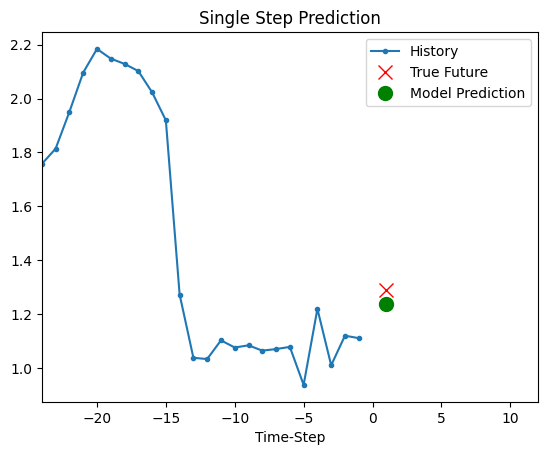

4/4 [==============================] - 0s 4ms/step


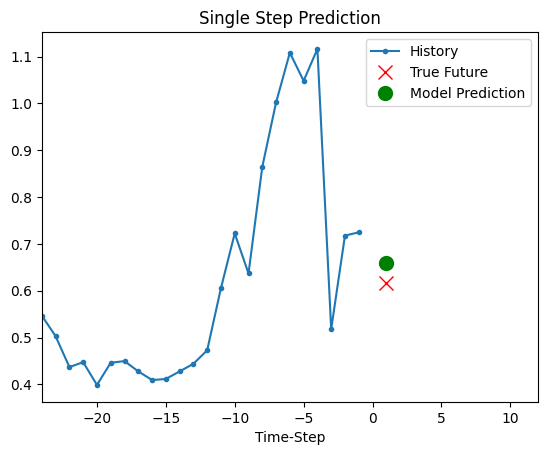

In [ ]:
for x, y in val_ds.take(3):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), lstm_model_2.predict(x)[0]],
        1,
        "Single Step Prediction",
    )

Tittar vi på några av modellens prediktioner så ligger den nära alla, som helhet bättre än tidigare LSTM-baseline även om den lyckades prediktera ett av de printade värdena otroligt bra.

*GRU-modellen*

In [ ]:
model_gru = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.GRU(32, return_sequences=True ,recurrent_regularizer=tf.keras.regularizers.l2(0.1)), # lägger in l2(ridge)-regularisering på recurrent-vikterna
    tf.keras.layers.GRU(16, return_sequences=False,recurrent_regularizer=tf.keras.regularizers.l2(0.01)), # lagt in ett  till lager med fler noder
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_target_features)
])


# Compile and train this model
history_gru,gru_model=compile_and_fit(model_gru)



Epoch 1/45
384/384 [==============================] - 15s 29ms/step - loss: 0.7231 - mean_squared_error: 0.0941 - val_loss: 0.0767 - val_mean_squared_error: 0.0434
Epoch 2/45
384/384 [==============================] - 11s 28ms/step - loss: 0.0563 - mean_squared_error: 0.0406 - val_loss: 0.0376 - val_mean_squared_error: 0.0298
Epoch 3/45
384/384 [==============================] - 11s 28ms/step - loss: 0.0384 - mean_squared_error: 0.0327 - val_loss: 0.0346 - val_mean_squared_error: 0.0310
Epoch 4/45
384/384 [==============================] - 11s 29ms/step - loss: 0.0331 - mean_squared_error: 0.0298 - val_loss: 0.0513 - val_mean_squared_error: 0.0490
Epoch 5/45
384/384 [==============================] - 11s 29ms/step - loss: 0.0347 - mean_squared_error: 0.0316 - val_loss: 0.0516 - val_mean_squared_error: 0.0495
Epoch 6/45
384/384 [==============================] - 11s 28ms/step - loss: 0.0322 - mean_squared_error: 0.0295 - val_loss: 0.0309 - val_mean_squared_error: 0.0289
Epoch 7/45
384/3

GRU-modellen överanpassart snabbt och presterar inte alls lika bra som de tidigare skapade modellerna, med de sagt är det möjligtvis förelaktigt att inte använda liknande lager osv för både LSTM och GRU.

In [ ]:
# MSE för modellen
pred_gru = gru_model.predict(test_ds)

MSE = np.mean((test_targets -np.array(pred_gru))**2) # beräknar MSE

print(MSE) # Printar MSE

55/55 [==============================] - 2s 18ms/step
0.026045591619350033


Test-MSE för GRU är högre än LSTM-baseline och är således den sämsta modellen av de 4 jag skapat inräknat med den naiva.

# Del 2

För den andra modellen kommer jag försöka att skapa ett eget utvärderingsmått som mäter på timme 24 framåt trots att modellen predikterar varje timme fram till dess.

Börjar med att ändra fönstret så att modellen siktar in sig rätt och inte  predikterar 1h framåt.


In [ ]:
# Ändrar fönstret så modellen endast predikterar 24h framåt
# Now create the used datasets for part 1
lcol=['T (degC)'] # väljer temperatur som target
train_ds = datasetgen(dfnorm, input_width=24, label_width=1, shift=24, # Ändrar shiften till 24h istället för 1
              label_columns=lcol, start_index=0, end_index=split1ix)
val_ds = datasetgen(dfnorm, input_width=24, label_width=1, shift=24,
              label_columns=lcol, start_index=split1ix, end_index=split2ix)
test_ds = datasetgen(dfnorm, input_width=24, label_width=1, shift=24,
              label_columns=lcol, start_index=split2ix, end_index=None)

# Establish test targets (unroll dataset)
test_targets = None
for batch in test_ds:
  inputs, targets = batch
  if test_targets == None:
    test_targets = targets
  else:
   test_targets = tf.concat([test_targets,targets], axis=0)

# And number of features
num_target_features = targets.shape[1]

lci = get_label_columns_indices(dfnorm,lcol)
# Get a batch and look at the shapes for one of the datasets
eval_ds = test_ds
for batch in eval_ds:
  inputs, targets = batch
  batchlen = len(inputs)
  # We here have a batch of seqlen sequences
  print("Input shape = {0}, Output shape = {1}".format(inputs.shape,targets.shape))
  break
# Print dataset size
nobatches = eval_ds.__len__()
print("No sequences =", nobatches.numpy() * batchlen)

Input shape = (128, 24, 19), Output shape = (128, 1)
No sequences = 7040


In [ ]:
# funktion för träningsproceduren
def compile_and_fit(model, patience=3):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', # Earlystopping
                                                    patience=patience,
                                                    mode='min',
                                                    restore_best_weights = True)

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanSquaredError()]) # bytt mått till MSE här

  history = model.fit(train_ds, epochs=MAX_EPOCHS,
                      validation_data=val_ds,
                      callbacks=[early_stopping])

  return history,model

# Define a first simple LSTM model with 32 units
lstm_model_3 = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True,recurrent_regularizer=tf.keras.regularizers.l2(0.1)), # lägger in l2(ridge)-regularisering på recurrent-vikterna
    tf.keras.layers.LSTM(16, return_sequences=False, recurrent_regularizer=tf.keras.regularizers.l2(0.01)), # lagt in ett  till lager med fler noder
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_target_features)
])

# Compile and train this model
history_mod3,lstm_model_3=compile_and_fit(lstm_model_3)


Epoch 1/45
384/384 [==============================] - 17s 31ms/step - loss: 0.8531 - mean_squared_error: 0.2297 - val_loss: 0.2325 - val_mean_squared_error: 0.1827
Epoch 2/45
384/384 [==============================] - 11s 29ms/step - loss: 0.1882 - mean_squared_error: 0.1611 - val_loss: 0.1876 - val_mean_squared_error: 0.1697
Epoch 3/45
384/384 [==============================] - 11s 29ms/step - loss: 0.1614 - mean_squared_error: 0.1492 - val_loss: 0.1676 - val_mean_squared_error: 0.1579
Epoch 4/45
384/384 [==============================] - 11s 29ms/step - loss: 0.1487 - mean_squared_error: 0.1414 - val_loss: 0.1622 - val_mean_squared_error: 0.1559
Epoch 5/45
384/384 [==============================] - 14s 37ms/step - loss: 0.1427 - mean_squared_error: 0.1375 - val_loss: 0.1586 - val_mean_squared_error: 0.1539
Epoch 6/45
384/384 [==============================] - 11s 29ms/step - loss: 0.1391 - mean_squared_error: 0.1349 - val_loss: 0.1567 - val_mean_squared_error: 0.1529
Epoch 7/45
384/3

Träningen stannar efter 25 epoker för att undvika överanpassning

In [ ]:

# MSE för modellen
pred_m3 = lstm_model_3.predict(test_ds)

MSE = np.mean((test_targets -np.array(pred_m3))**2) # beräknar MSE

print(MSE) # Printar MSE

55/55 [==============================] - 54s 17ms/step
0.1167562120970866


Test-MSE är 0.117

In [ ]:
def last_time_step_mse(Y_true, Y_pred):
   Y_true= Y_true[::24, ]  # Väljer varje 24:e timme
   Y_pred= Y_pred[::24, ]
   return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])



MAX_EPOCHS = 45

# funktion för träningsproceduren
def compile_and_fit(model, patience=3):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', # Earlystopping
                                                    patience=patience,
                                                    mode='min',
                                                    restore_best_weights = True)

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[last_time_step_mse]) # bytt mått till MSE här

  history = model.fit(train_ds, epochs=MAX_EPOCHS,
                      validation_data=val_ds,
                      callbacks=[early_stopping])

  return history,model




Ändrar fönstret igen, så att modellen predikterar varje värde fram till 24h framåt av de senaste 24 timmarna

In [ ]:
# Ändrar fönstret så modellen endast predikterar 24h framåt
# Now create the used datasets for part 1
lcol=['T (degC)'] # väljer temperatur som target
train_ds = datasetgen(dfnorm, input_width=24, label_width=24, shift=1, # Ändrar shiften till 1 men ändrar label_width till 24 då 24 värden ska predikteras
              label_columns=lcol, start_index=0, end_index=split1ix)
val_ds = datasetgen(dfnorm, input_width=24, label_width=24, shift=1,
              label_columns=lcol, start_index=split1ix, end_index=split2ix)
test_ds = datasetgen(dfnorm, input_width=24, label_width=24, shift=1,
              label_columns=lcol, start_index=split2ix, end_index=None)

# Establish test targets (unroll dataset)
test_targets = None
for batch in test_ds:
  inputs, targets = batch
  if test_targets == None:
    test_targets = targets
  else:
   test_targets = tf.concat([test_targets,targets], axis=0)

# And number of features
num_target_features = targets.shape[1]

lci = get_label_columns_indices(dfnorm,lcol)
# Get a batch and look at the shapes for one of the datasets
eval_ds = test_ds
for batch in eval_ds:
  inputs, targets = batch
  batchlen = len(inputs)
  # We here have a batch of seqlen sequences
  print("Input shape = {0}, Output shape = {1}".format(inputs.shape,targets.shape))
  break
# Print dataset size
nobatches = eval_ds.__len__()
print("No sequences =", nobatches.numpy() * batchlen)

Input shape = (128, 24, 19), Output shape = (128, 1)
No sequences = 7040


In [ ]:

# Define a first simple LSTM model with 32 units
lstm_model_4 = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True,recurrent_regularizer=tf.keras.regularizers.l2(0.1)), # lägger in l2(ridge)-regularisering på recurrent-vikterna
    tf.keras.layers.LSTM(16, return_sequences=False, recurrent_regularizer=tf.keras.regularizers.l2(0.01)), # lagt in ett  till lager med fler noder
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_target_features)
])

# Compile and train this model
history_mod4,lstm_model_4=compile_and_fit(lstm_model_4)


Epoch 1/45
384/384 [==============================] - 17s 31ms/step - loss: 0.7243 - last_time_step_mse: 0.1562 - val_loss: 0.0961 - val_last_time_step_mse: 0.0614
Epoch 2/45
384/384 [==============================] - 11s 30ms/step - loss: 0.0739 - last_time_step_mse: 0.0567 - val_loss: 0.0616 - val_last_time_step_mse: 0.0505
Epoch 3/45
384/384 [==============================] - 11s 29ms/step - loss: 0.0515 - last_time_step_mse: 0.0457 - val_loss: 0.0486 - val_last_time_step_mse: 0.0449
Epoch 4/45
384/384 [==============================] - 11s 29ms/step - loss: 0.0419 - last_time_step_mse: 0.0392 - val_loss: 0.0472 - val_last_time_step_mse: 0.0471
Epoch 5/45
384/384 [==============================] - 11s 29ms/step - loss: 0.0366 - last_time_step_mse: 0.0349 - val_loss: 0.0477 - val_last_time_step_mse: 0.0490
Epoch 6/45
384/384 [==============================] - 11s 29ms/step - loss: 0.0336 - last_time_step_mse: 0.0324 - val_loss: 0.0460 - val_last_time_step_mse: 0.0474
Epoch 7/45
384/3

Modellen stannar efter 35 epoker

In [ ]:

# MSE för modellen
pred_m4 = lstm_model_4.predict(test_ds)

MSE = np.mean((test_targets[::24] -np.array(pred_m4[::24]))**2) # beräknar MSE för varje 24e timme

print(MSE) # Printar MSE

55/55 [==============================] - 2s 18ms/step
0.010675635170015952


Modellen får ett test-MSE för varje 24e predikterade timme på 0.0107 vilket är mycket lägre än modellen som endast predikterar 24h framåt och inte varje timme 24h framåt. Skillnaden i resultat är otroligt stora och att låta modellen träna på att prediktera flera värden för samma intervallstorlek förbättrar prediktionerna avsevärt.

Att den här modellen får lägst MSE av alla modeller är lite konstigt då en kortare prediktion bör vara mer pricksäker. Men det som gör att den sista modellen presterar bra måste vara att det är ett dygnsmönster som är lättare att prediktera än vad som variarer timme för timme. Samtidigt fick inte min bästa modell som endast predikterar ett steg framåt tränas klart och därav är det lite orättvist att jämföra modellerna.


# VG del

Ändrar tillbaka fönstret så endast ett steg framåt predikteras men ändrar också så att alla labels predikteras och inte endast temperaturen

In [ ]:
# Ändrar fönstret tillbaka så den endast predikterar 1 steg, men ändrar så alla labels är med
# Now create the used datasets for part 1
lcol= None
lci = get_label_columns_indices(dfnorm,lcol)
lcol=lci
train_ds = datasetgen(dfnorm, input_width=24, label_width=1, shift=1, # Ändrar label_width till 1
              label_columns=lcol, start_index=0, end_index=split1ix)
val_ds = datasetgen(dfnorm, input_width=24, label_width=1, shift=1,
              label_columns=lcol, start_index=split1ix, end_index=split2ix)
test_ds = datasetgen(dfnorm, input_width=24, label_width=1, shift=1,
              label_columns=lcol, start_index=split2ix, end_index=None)

print(lci)


{'p (mbar)': 0, 'T (degC)': 1, 'Tpot (K)': 2, 'Tdew (degC)': 3, 'rh (%)': 4, 'VPmax (mbar)': 5, 'VPact (mbar)': 6, 'VPdef (mbar)': 7, 'sh (g/kg)': 8, 'H2OC (mmol/mol)': 9, 'rho (g/m**3)': 10, 'Wx': 11, 'Wy': 12, 'max Wx': 13, 'max Wy': 14, 'Day sin': 15, 'Day cos': 16, 'Year sin': 17, 'Year cos': 18}


In [ ]:
# Establish test targets (unroll dataset)
test_targets = None
for batch in test_ds:
  inputs, targets = batch
  if test_targets == None:
    test_targets = targets
  else:
   test_targets = tf.concat([test_targets,targets], axis=0)

# And number of features
num_target_features = targets.shape[1]

lci = get_label_columns_indices(dfnorm,lcol)
# Get a batch and look at the shapes for one of the datasets
eval_ds = test_ds
for batch in eval_ds:
  inputs, targets = batch
  batchlen = len(inputs)
  # We here have a batch of seqlen sequences
  print("Input shape = {0}, Output shape = {1}".format(inputs.shape,targets.shape))
  break
# Print dataset size
nobatches = eval_ds.__len__()
print("No sequences =", nobatches.numpy() * batchlen)



Input shape = (128, 24, 19), Output shape = (128, 19)
No sequences = 7040


Vi ser nu att outputen är 19 istället för 1

In [ ]:
# Define a first simple LSTM model with 32 units
lstm_model_5 = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True,recurrent_regularizer=tf.keras.regularizers.l2(0.1)), # lägger in l2(ridge)-regularisering på recurrent-vikterna
    tf.keras.layers.LSTM(16, return_sequences=False, recurrent_regularizer=tf.keras.regularizers.l2(0.01)), # lagt in ett  till lager med fler noder
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_target_features)
])

# Compile and train this model
history_mod5,lstm_model_5=compile_and_fit(lstm_model_5)


Epoch 1/45
384/384 [==============================] - 24s 44ms/step - loss: 1.0770 - last_time_step_mse: 0.4507 - val_loss: 0.3329 - val_last_time_step_mse: 0.2823
Epoch 2/45
384/384 [==============================] - 11s 29ms/step - loss: 0.2618 - last_time_step_mse: 0.1736 - val_loss: 0.2078 - val_last_time_step_mse: 0.1478
Epoch 3/45
384/384 [==============================] - 11s 30ms/step - loss: 0.1885 - last_time_step_mse: 0.1115 - val_loss: 0.1733 - val_last_time_step_mse: 0.0835
Epoch 4/45
384/384 [==============================] - 11s 30ms/step - loss: 0.1600 - last_time_step_mse: 0.0658 - val_loss: 0.1630 - val_last_time_step_mse: 0.0507
Epoch 5/45
384/384 [==============================] - 11s 29ms/step - loss: 0.1446 - last_time_step_mse: 0.0411 - val_loss: 0.1507 - val_last_time_step_mse: 0.0314
Epoch 6/45
384/384 [==============================] - 12s 30ms/step - loss: 0.1345 - last_time_step_mse: 0.0295 - val_loss: 0.1405 - val_last_time_step_mse: 0.0205
Epoch 7/45
384/3

In [ ]:
# MSE för modellen
pred_m5 = lstm_model_5.predict(test_ds)

MSE = np.mean((test_targets[::24] -np.array(pred_m5[::24]))**2) # beräknar MSE för varje 24e timme

print(MSE) # Printar MSE

55/55 [==============================] - 1s 19ms/step
0.09079364648077426


Generellt över alla 19 variabler har prediktioner varje 24e timme en  MSE på 0.0907

In [ ]:

df = test_ds.take(1)  # kopierar testmängdens 24 första värden, alltså 1 sekvens

# loop för att lägga in nya värden i predikt
for i in range(24):

  df_pred = lstm_model_5.predict(df) # Skapar prediktioner
  output = df_pred[-1] # tar ut de sista värdena för att lägga in i nya prediktioner




Lyckades inte indexera in raderna från en array med prediktioner till samma dimensioner som ett tensorflow-dataset, för att kunna loopa över 24 timmar där varje ny prediktion blir den senaste timmen i datasetet.